In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

# 2 The Factors
### Data

In [10]:
factor_ret = pd.read_excel("../data/factor_pricing_data.xlsx", sheet_name=1, index_col=0)
port_ret = pd.read_excel("../data/factor_pricing_data.xlsx", sheet_name=2, index_col=0)

### Functions

In [6]:
def summary_stat(df, annual_factor, q=0.05):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["Sharpe Ratio"] = result["mean"]/result["volatility"]

    # result["VaR"] = df.quantile(q)
    return result

In [22]:
def cal_excess_tangency(df_ex, annual_factor):
    N = df_ex.shape[1]

    Sigma = df_ex.cov() * annual_factor
    Sigma_inv = np.linalg.inv(Sigma)
    mean_ex = df_ex.mean() * annual_factor

    w_t = 1/(np.ones(N) @ Sigma_inv @ mean_ex) * Sigma_inv @ mean_ex
    return pd.Series(w_t, index=df_ex.columns)

## 1 Analyze the factors, compare there univariate statistics.

In [31]:
summary = summary_stat(factor_ret, annual_factor=12)
summary

,mean,volatility,Sharpe Ratio
MKT,0.0831,0.1567,0.5305
SMB,0.0122,0.1005,0.1211
HML,0.0275,0.1088,0.2529
RMW,0.0448,0.0834,0.5376
CMA,0.0333,0.0715,0.4652
UMD,0.0655,0.1545,0.4241


## 2 Based on the factor statistics above, answer the following.
### (a) Does each factor have a positive risk premium 

Yes. Each factor has a positive risk premium. 

### (b) How have the factors performed since the time of the case

* Size factor and value factor didn't preformed well and have a negative risk premium.
* The risk premium for all factors except market is reduced.

In [30]:
subsample = factor_ret.loc["2015":].copy()
sub_summary = summary_stat(subsample, annual_factor=12)
sub_summary

,mean,volatility,Sharpe Ratio
MKT,0.1069,0.1602,0.6676
SMB,-0.0058,0.0977,-0.0590
HML,-0.0197,0.1325,-0.1488
RMW,0.0395,0.0712,0.5553
CMA,0.0022,0.0796,0.0282
UMD,0.0255,0.1368,0.1865


## 3 Report the correlation matrix across the six factors.
### (a) Does the construction method succeed in keeping correlations small?

* Yes. Value factor and Investment factor have a relatively higher correlation of 0.67, other factors have a low correlation.

In [15]:
corr_matrix = factor_ret.corr()
corr_matrix

,MKT,SMB,HML,RMW,CMA,UMD
MKT,1.0000,0.2263,-0.2221,-0.2554,-0.3819,-0.1677
SMB,0.2263,1.0000,-0.0721,-0.4143,-0.0642,-0.0304
HML,-0.2221,-0.0721,1.0000,0.2295,0.6725,-0.2349
RMW,-0.2554,-0.4143,0.2295,1.0000,0.1155,0.0753
CMA,-0.3819,-0.0642,0.6725,0.1155,1.0000,-0.0122
UMD,-0.1677,-0.0304,-0.2349,0.0753,-0.0122,1.0000


<AxesSubplot: >

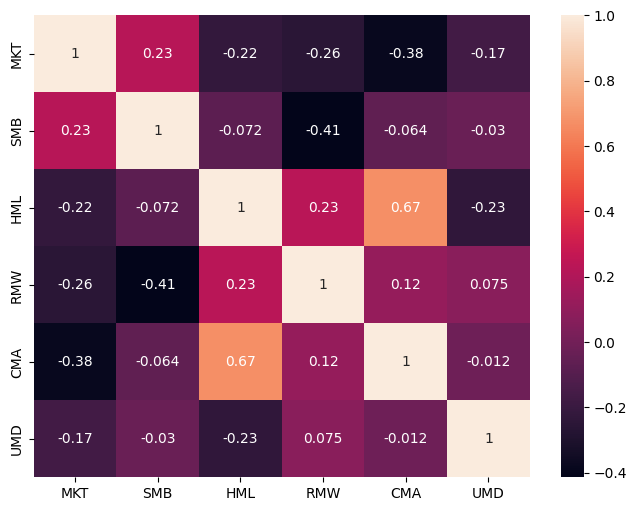

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True)

### (b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

* Yes. HML has a similar performance to CMA factor. 


<AxesSubplot: xlabel='Date'>

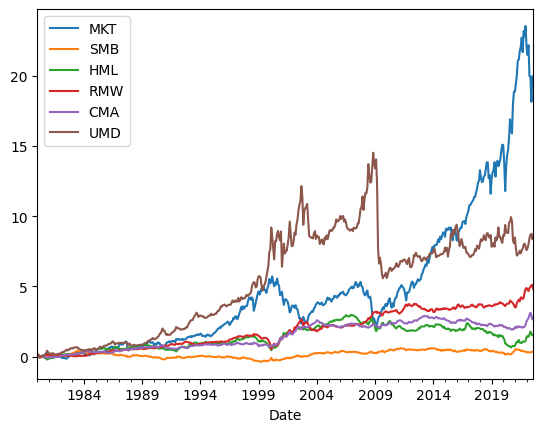

In [20]:
factor_cum_ret = (factor_ret + 1).cumprod() - 1
factor_cum_ret.plot()

<AxesSubplot: xlabel='Date'>

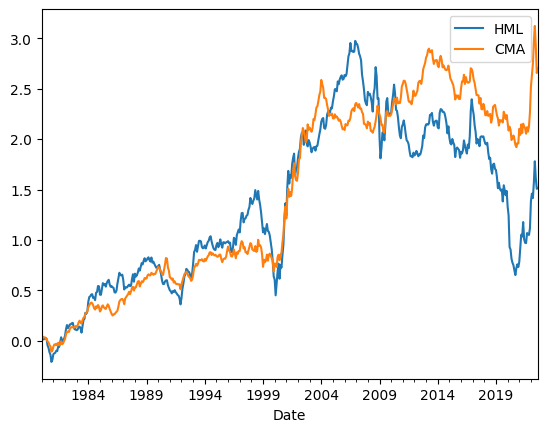

In [21]:
factor_cum_ret[["HML", "CMA"]].plot()

## 4 Report the tangency weights for a portfolio of these 6 factors.Report the tangency weights for a portfolio of these 6 factors.

### (a) Which factors seem most important? And Least?

* CMA, RMW, and the MKT seem like the most important factors as they have the largest weights. HML, SMB, and UMD have lower weights so we could say that they seem less important. 
* Due to the correlaiton of CMA and HML, CMA has the highest weight and HML has the lowest weight.


In [43]:
tangency_weight = cal_excess_tangency(factor_ret, annual_factor=12)
tangency_weight = tangency_weight.to_frame(name="weight")

In [49]:
tangency_weight.sort_values(by="weight", ascending=False)

,weight
CMA,0.3774
RMW,0.2884
MKT,0.2011
UMD,0.0986
SMB,0.0816
HML,-0.0470


### (b) Are the factors with low mean returns still useful?
* Yes. CMA has one of the lower mean returns but the highest allocation.

In [42]:
pd.merge(tangency_weight, summary[["mean"]], left_index=True, right_index=True).sort_values(by="mean")


,weight,mean
SMB,0.0816,0.0122
HML,-0.0470,0.0275
CMA,0.3774,0.0333
RMW,0.2884,0.0448
UMD,0.0986,0.0655
MKT,0.2011,0.0831


### (c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

* SMB get lowest weight and HML get highest weight. 

In [51]:
subsample = factor_ret[["MKT", "SMB", "HML", "UMD"]].copy()
tan_w_sub = cal_excess_tangency(subsample, annual_factor=12)
tan_w_sub.to_frame(name="weight").sort_values(by="weight")

,weight
SMB,0.0061
UMD,0.3003
MKT,0.3314
HML,0.3622


### What do you conclude about the importance or unimportance of these styles?
* Due to the correlation between HML and CMA, the regression coefficient of HML is small and that of CMA is large. If we treat these two as one type of factor, then it matters. 
* MKT factor always matters, SMB has relatively small weight.
* The importance of these styles is very much based on correlation between the factors.

# 3 Testing Modern LPMs
### Data

In [53]:
CAPM = factor_ret[["MKT"]].copy()
FF3F = factor_ret[["MKT", "SMB", "HML"]].copy()
FF5F = factor_ret[["MKT", "SMB", "HML", "RMW", "CMA"]].copy()
AQR = factor_ret[["MKT", "HML", "RMW", "UMD"]].copy()

### Functions

In [133]:
def get_capm_matrics(targets, regressors, add_constant=True, annualize_factor=12):

    result = pd.DataFrame(index=targets.columns)
    resid_matrix = pd.DataFrame(columns=targets.columns)
    t_p_value = pd.DataFrame(index=targets.columns)

    if add_constant:
        X = sm.add_constant(regressors)
    else:
        X = regressors.copy()
    for column in targets.columns:
        y = targets[[column]]
        model = sm.OLS(y, X, missing='drop').fit()
        if add_constant:
            result.loc[column, "alpha"] = model.params['const'] * \
                annualize_factor
        result.loc[column, regressors.columns] = model.params[regressors.columns]

        result.loc[column, "R-squared"] = model.rsquared

        resid_matrix[column] = model.resid
        if add_constant:
            t_p_value.loc[column, "t-value"] = model.tvalues['const']
            t_p_value.loc[column, "p-value"] = model.pvalues['const']

    return result, resid_matrix, t_p_value

## 1 Test the AQR 4-Factor Model using the time-series test. 
### (a) For each regression, report the estimated α and r-squared.

In [67]:
AQR_result, resid_matrix1, t_p_value1 = get_capm_matrics(
    port_ret, AQR, add_constant=True, annualize_factor=12)

In [69]:
AQR_result[["alpha", "R-squared"]]

,alpha,R-squared
Agric,1.5617e-02,0.3302
Food,1.5205e-02,0.4681
Soda,2.3801e-02,0.3098
Beer,2.6757e-02,0.4248
Smoke,3.9908e-02,0.2575
Toys,-2.7704e-02,0.5033
Fun,2.7091e-02,0.6156
Books,-2.9218e-02,0.6886
Hshld,-8.9017e-04,0.5681
Clths,-1.3642e-03,0.6185


### (b) Calculate the mean-absolute-error of the estimated alphas

Small or large?  Does this seem to support the pricing model or not?

* If pricing model worked, alpha should be small.
* Based on the MAE stat, AQR's pricing model seems to work. 

In [72]:
MAE = np.abs(AQR_result["alpha"]).mean()
MAE

0.023469781206195417

## 2 Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [94]:
CAPM_result, resid_matrix1, t_p_value1 = get_capm_matrics(
    port_ret, CAPM, add_constant=True, annualize_factor=12)
FF3F_result, resid_matrix1, t_p_value1 = get_capm_matrics(
    port_ret, FF3F, add_constant=True, annualize_factor=12)
FF5F_result, resid_matrix1, t_p_value1 = get_capm_matrics(
    port_ret, FF5F, add_constant=True, annualize_factor=12)

In [75]:
alpha_res = pd.concat([CAPM_result[["alpha"]], FF3F_result[["alpha"]], FF5F_result[["alpha"]], AQR_result[["alpha"]]], axis=1)
alpha_res.columns = ["CAPM", "FF3F", "FF5F", "AQR"]
alpha_res

,CAPM,FF3F,FF5F,AQR
Agric,0.0276,0.0225,1.5617e-02,1.5617e-02
Food,0.0540,0.0453,1.5205e-02,1.5205e-02
Soda,0.0519,0.0393,2.3801e-02,2.3801e-02
Beer,0.0673,0.0649,2.6757e-02,2.6757e-02
Smoke,0.0821,0.0695,3.9908e-02,3.9908e-02
Toys,-0.0270,-0.0289,-2.7704e-02,-2.7704e-02
Fun,0.0049,0.0018,2.7091e-02,2.7091e-02
Books,-0.0146,-0.0279,-2.9218e-02,-2.9218e-02
Hshld,0.0250,0.0232,-8.9017e-04,-8.9017e-04
Clths,0.0139,0.0067,-1.3642e-03,-1.3642e-03


In [81]:
np.abs(alpha_res).mean().to_frame(name="MAE")

,MAE
CAPM,0.0215
FF3F,0.0254
FF5F,0.0235
AQR,0.0235


**Answers:** CAPM fits the best and has the lowest MAE.

## 3 Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

* The market factor seems very important for pricing as all models include it and the CAPM performs the best. 
* Yes. Momentum factor should be considered as AQR uses it and their model performs better in terms of MAE. Also, momentum factor add portfolio diversify benifits because of the low correlation of momentum factor to other factor. 

## 4 Report the average (across n estimations) of the time-series regression r-squared statistics.

Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

**Answers:** These models do not lead to high time-series $R^{2}$ stats. Thus, they would not be good in a Linear Factor Decomposition of the assets. 

In [84]:
r_squared = pd.concat([CAPM_result[["R-squared"]], FF3F_result[[
                      "R-squared"]], FF5F_result[["R-squared"]], AQR_result[["R-squared"]]], axis=1)
r_squared.columns = ["CAPM", "FF3F", "FF5F", "AQR"]
r_squared.mean().to_frame("R-squared")

,R-squared
CAPM,0.5275
FF3F,0.5711
FF5F,0.5757
AQR,0.5757


## 5 Time-series test and cross-sectional test.
### (a) Report the time-series premia of the factors and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [92]:
FF5F_result

,alpha,MKT,HML,RMW,UMD,R-squared
Agric,1.5617e-02,0.8209,0.1557,-0.0223,0.0872,0.3302
Food,1.5205e-02,0.6826,0.1634,0.5255,0.0344,0.4681
Soda,2.3801e-02,0.7911,0.2073,0.4887,-0.0974,0.3098
Beer,2.6757e-02,0.7272,0.0127,0.6050,0.0763,0.4248
Smoke,3.9908e-02,0.7227,0.2120,0.6564,-0.0403,0.2575
Toys,-2.7704e-02,1.1111,-0.0539,0.2436,-0.1369,0.5033
Fun,2.7091e-02,1.2383,0.0021,-0.1113,-0.2025,0.6156
Books,-2.9218e-02,1.1088,0.2705,0.1685,-0.0725,0.6886
Hshld,-8.9017e-04,0.7549,-0.0145,0.4694,0.0022,0.5681
Clths,-1.3642e-03,1.0987,0.0107,0.5600,-0.2099,0.6185


In [95]:
TS_beta_CAPM = CAPM_result[["MKT"]]
TS_beta_FF3F = FF3F_result[["MKT", "SMB", "HML"]]
TS_beta_FF5F = FF5F_result[["MKT", "SMB", "HML", "RMW", "CMA"]]
TS_beta_AQR = AQR_result[["MKT", "HML", "RMW", "UMD"]]

In [116]:
(factor_ret.mean()*12).to_frame("TS Premia")

,TS Premia
MKT,0.0831
SMB,0.0122
HML,0.0275
RMW,0.0448
CMA,0.0333
UMD,0.0655


In [145]:
# cross-sectional regression
y = (port_ret.mean()*12).to_frame("port_mean_return")

CS_CAPM, resid_CAPM, _ = get_capm_matrics(
    y, TS_beta_CAPM, add_constant=True, annualize_factor=1)
CS_FF3F, resid_FF3F, _ = get_capm_matrics(
    y, TS_beta_FF3F, add_constant=True, annualize_factor=1)
CS_FF5F, resid_FF5F, _ = get_capm_matrics(
    y, TS_beta_FF5F, add_constant=True, annualize_factor=1)
CS_AQR, resid_AQR, _ = get_capm_matrics(
    y, TS_beta_AQR, add_constant=True, annualize_factor=1)

result = pd.concat([CS_CAPM, CS_FF3F, CS_FF5F, CS_AQR])
result.index = pd.Series(["CS_CAPM", "CS_FF3F", "CS_FF5F", "CS_AQR"])
result = result[["MKT", "SMB", "HML", "RMW", "CMA", "UMD"]]

In [146]:
result.T

,CS_CAPM,CS_FF3F,CS_FF5F,CS_AQR
MKT,-0.0013,0.0299,0.0362,0.0078
SMB,NaN,-0.0427,-0.0456,NaN
HML,NaN,-0.0207,-0.0278,-0.0326
RMW,NaN,NaN,0.0247,0.0222
CMA,NaN,NaN,-0.0231,NaN
UMD,NaN,NaN,NaN,-0.0062


In [147]:
CS_CAPM, _, _ = get_capm_matrics(
    y, TS_beta_CAPM, add_constant=False, annualize_factor=1)
CS_FF3F, _, _ = get_capm_matrics(
    y, TS_beta_FF3F, add_constant=False, annualize_factor=1)
CS_FF5F, _, _ = get_capm_matrics(
    y, TS_beta_FF5F, add_constant=False, annualize_factor=1)
CS_AQR, _, _ = get_capm_matrics(
    y, TS_beta_AQR, add_constant=False, annualize_factor=1)

result = pd.concat([CS_CAPM, CS_FF3F, CS_FF5F, CS_AQR])
result.index = pd.Series(["CS_CAPM", "CS_FF3F", "CS_FF5F", "CS_AQR"])
result = result[["MKT", "SMB", "HML", "RMW", "CMA", "UMD"]]


In [148]:
result.T

,CS_CAPM,CS_FF3F,CS_FF5F,CS_AQR
MKT,0.0849,0.1010,0.0948,0.0866
SMB,NaN,-0.0659,-0.0587,NaN
HML,NaN,-0.0173,-0.0354,-0.0409
RMW,NaN,NaN,0.0368,0.0455
CMA,NaN,NaN,-0.0154,NaN
UMD,NaN,NaN,NaN,0.0553


**Answers:** If we add an constant, the cross-sectionally estimated premia vary quite a bit.

### Report the MAE of the cross-sectional regression residuals for each of the four models, (the υi.) How do they compare to the MAE of the time-series alphas?

In [153]:
MAE_res = pd.concat([resid_CAPM, resid_FF3F, resid_FF5F, resid_AQR], axis=1)
MAE_res.columns = ["CAPM", "FF3F", "FF5F", "AQR"]
MAE_res

,CAPM,FF3F,FF5F,AQR
Agric,0.0020,0.0149,1.8490e-02,0.0099
Food,0.0112,0.0053,4.6961e-03,0.0082
Soda,0.0199,0.0174,1.6635e-02,0.0173
Beer,0.0287,0.0169,1.3781e-02,0.0189
Smoke,0.0416,0.0336,3.3119e-02,0.0364
Toys,-0.0253,-0.0191,-2.2946e-02,-0.0342
Fun,0.0217,0.0191,1.9371e-02,0.0208
Books,-0.0173,-0.0136,-1.3578e-02,-0.0135
Hshld,-0.0083,-0.0171,-1.8736e-02,-0.0167
Clths,0.0112,0.0098,3.6823e-04,-0.0030


In [155]:
MAE_alpha_m = np.abs(alpha_res).mean().to_frame(name="MAE")
MAE_res_m = np.abs(MAE_res).mean().to_frame("MAE_resid")
pd.merge(MAE_alpha_m, MAE_res_m, left_index=True, right_index=True)

,MAE,MAE_resid
CAPM,0.0215,0.0156
FF3F,0.0254,0.0121
FF5F,0.0235,0.0116
AQR,0.0235,0.0137
